# Analysis Plan

1. Check normality in demographics
2. Transform value choices to cosine distance from expected assignments
3. Check bias in data: Any correlations between value choices and demographic data?
4. Determine power
5. Determine significance

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kendalltau, linregress

In [26]:
data_df = pd.read_csv('./data/study-responses.csv')
data_df.head()

,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,age,gender,education,reading,years_gaming,gaming_per_week,familiarity
0,5,5,7,2,5,1,1,7,4,29,0,1,0,0,2,2
1,5,5,7,8,4,1,1,3,4,25,1,2,1,0,2,2
2,5,7,3,8,5,0,0,5,4,22,1,1,1,0,0,1
3,4,5,7,8,4,0,0,3,4,28,0,3,1,0,0,0
4,5,5,7,8,5,4,4,5,4,35,0,1,1,0,2,3


## Visualize demographics data

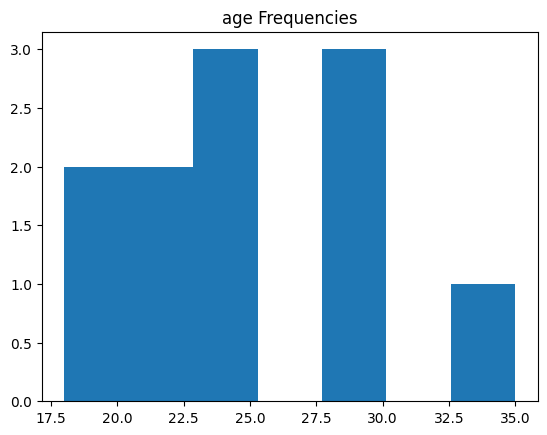

Shapiro-Wilks test: 0.6795324087142944


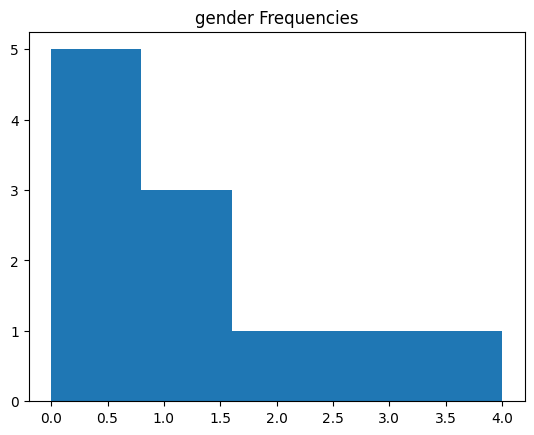

Shapiro-Wilks test: 0.010697395540773869


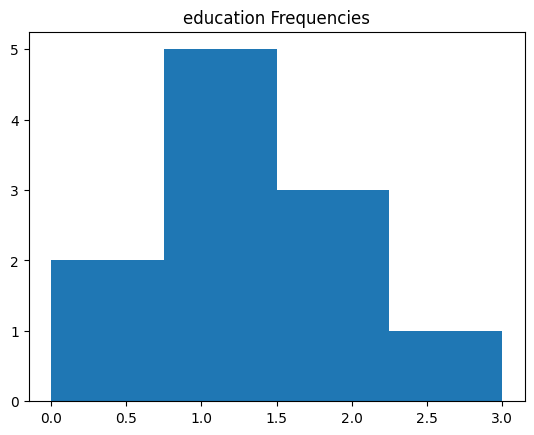

Shapiro-Wilks test: 0.1806650608778


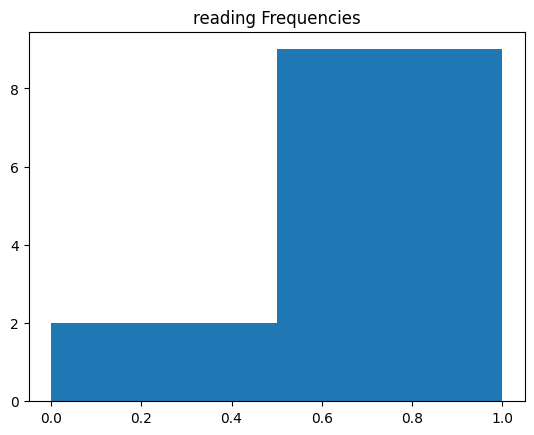

Shapiro-Wilks test: 1.0208648291154532e-06


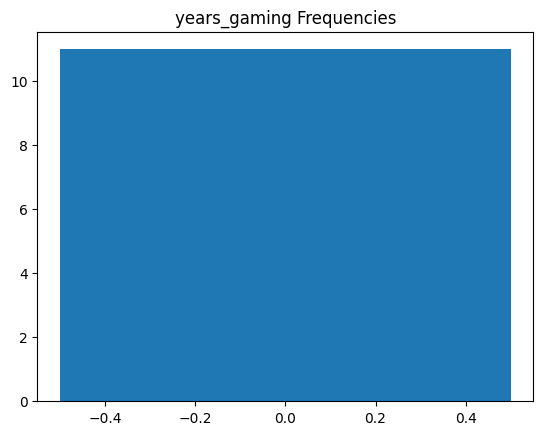

Shapiro-Wilks test: 1.0


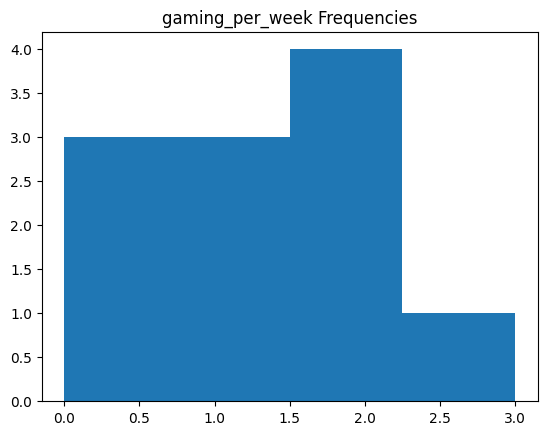

Shapiro-Wilks test: 0.1341048926115036


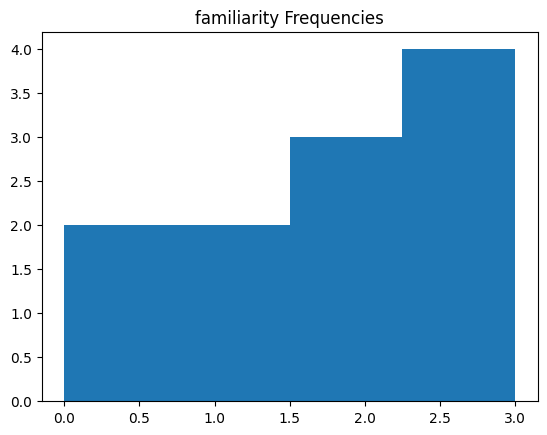

Shapiro-Wilks test: 0.04857904836535454


In [49]:
demo_columns = ['age', 'gender', 'education', 'reading', 'years_gaming', 'gaming_per_week', 'familiarity']
ticks = [[
    18,
    22,
    24,
    25,
    28,
    29,
    35,
], [
    'male', 'female', 'nonbinary', 'don\'t know', 'none'
], [
    'high school', 'bachelor degree', 'master degree', 'doctorate'
], [
    'somewhat confident', 'extremely confident'
], [
    '5+ years'
], [
   '0-5',
    '5-10',
    '10-20',
    '20+'
], [
    'somewhat unfamiliar', 'neither familiar nor unfamiliar', 'somewhat familiar', 'very familiar'
]]

for idx, col in enumerate(demo_columns):
    # get the column from the df
    column_s = data_df[col]
    if not column_s.dtype == 'int64':
        continue
    # visualize with histogram
    figure = plt.figure()
    counts, bins = np.histogram(column_s) 
    plt.hist(column_s, bins=len(set(column_s)), label=ticks[idx])
    
    plt.title(f'{col} Frequencies')
    plt.show()
    # shapiro wilk test for normality
    res = shapiro(column_s)
    print(f'Shapiro-Wilks test: {res.pvalue}')
    

In [44]:
### Same as above, but with value assignments

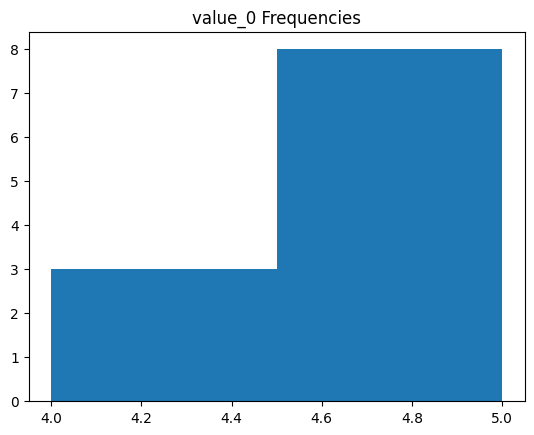

Shapiro-Wilks test: 1.1574424206628464e-05


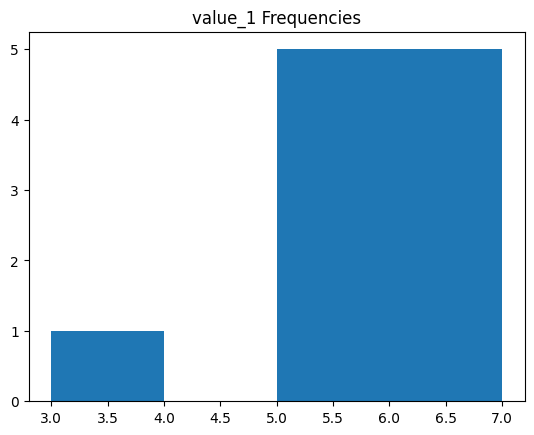

Shapiro-Wilks test: 0.0658673569560051


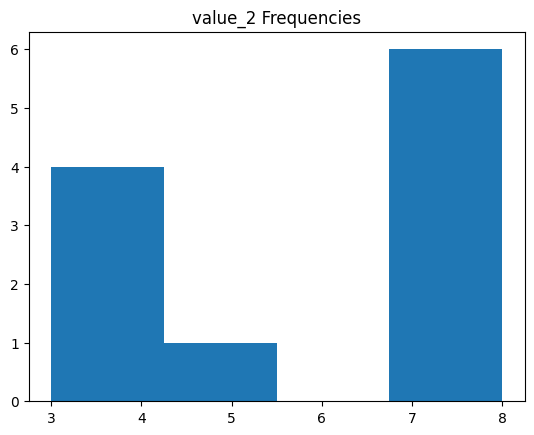

Shapiro-Wilks test: 0.004017770756036043


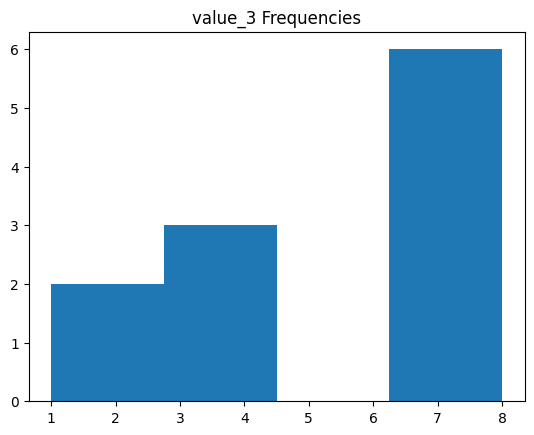

Shapiro-Wilks test: 0.001552721718326211


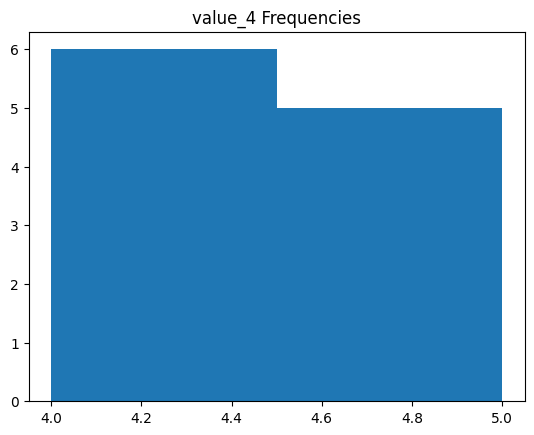

Shapiro-Wilks test: 0.00010517357441131026


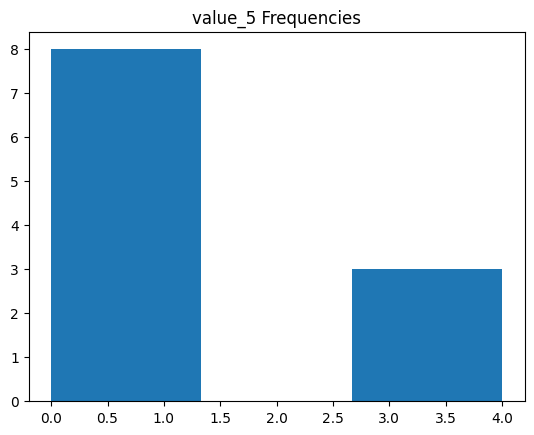

Shapiro-Wilks test: 0.001581458724103868


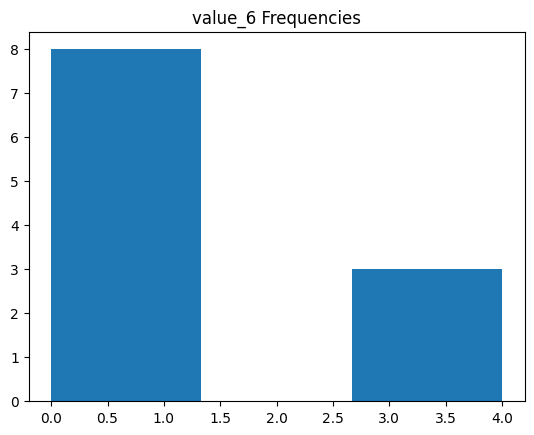

Shapiro-Wilks test: 0.0007987188291735947


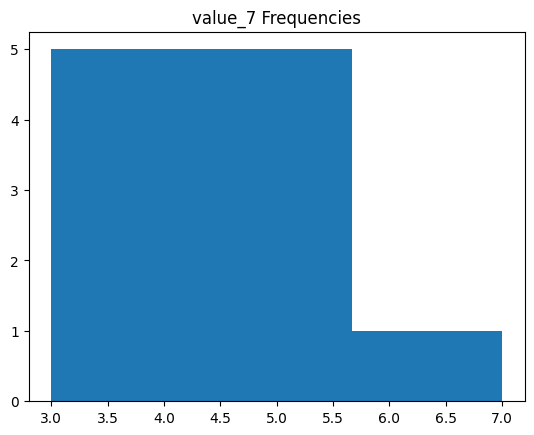

Shapiro-Wilks test: 0.006226326338946819


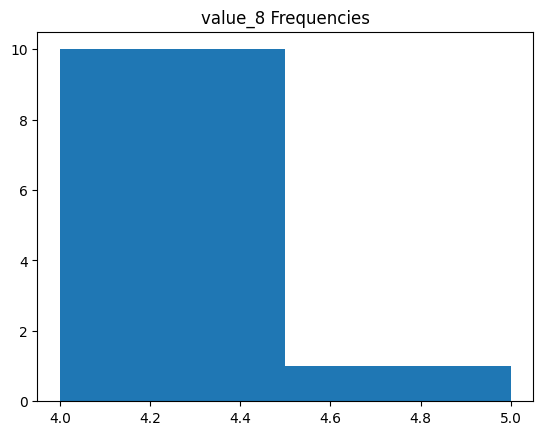

Shapiro-Wilks test: 2.2434040403140898e-08


In [45]:
value_assignment_columns = [ f'value_{i}' for i in range(9) ]

for idx, col in enumerate(value_assignment_columns):
    # get the column from the df
    column_s = data_df[col]
    if not column_s.dtype == 'int64':
        continue
    # visualize with histogram
    figure = plt.figure()
    counts, bins = np.histogram(column_s) 
    plt.hist(column_s, bins=len(set(column_s)))
    
    plt.title(f'{col} Frequencies')
    plt.show()
    # shapiro wilk test for normality
    res = shapiro(column_s)
    print(f'Shapiro-Wilks test: {res.pvalue}')

## Test Correlations

In [64]:
subplot_height = len(columns)
subplot_width = 9

demo_types = ['interval', 'nominal', 'ordinal', 'ordinal', 'ordinal', 'ordinal', 'ordinal']
alpha = 0.05

corr_df = []
sig_corr_df = []
for idx, demo in enumerate(demo_columns):
    results = { 'demographic': demo }
    sig_results = { 'demographic': demo }
    for jdx, assignment in enumerate(value_assignment_columns):
        if demo_types[idx] == 'nominal':
            corr = linregress(data_df[demo], data_df[assignment])
            results[assignment] = f'{corr.slope}, p={corr.pvalue}'
            
            if corr.pvalue < alpha:
                sig_results[assignment] = f'{corr.slope}, p={corr.pvalue}'
        else:
            corr = kendalltau(data_df[demo], data_df[assignment])
            results[assignment] = f'{corr.statistic}, p={corr.pvalue}'
            if corr.pvalue < alpha:
                sig_results[assignment] = f'{corr.statistic}, p={corr.pvalue}'
    
    corr_df.append(results)
    sig_corr_df.append(sig_results)
    
corr_df = pd.DataFrame(corr_df)
sig_corr_df = pd.DataFrame(sig_corr_df)
display(corr_df)

,demographic,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8
0,age,"0.4001633653325206, p=0.1492914861252213","-0.21868700842034766, p=0.3991755073859128","0.08968970586617499, p=0.7323848237368196","-0.046040925551613085, p=0.860919778501674","0.5113099925649136, p=0.06539191562183343","0.2656844656620286, p=0.3123723306913847","0.49329338226396247, p=0.0612543462664159","0.4023739080814782, p=0.13463702149267118","0.3099652099390333, p=0.2639950553159284"
1,gender,"0.014423076923076919, p=0.9013509721926254","0.12980769230769232, p=0.6660548106081607","-0.12980769230769235, p=0.8006888314591551","0.29326923076923084, p=0.6914417870370213","0.02884615384615384, p=0.824344928383234","0.6634615384615384, p=0.0876031125046332","0.40384615384615385, p=0.3409988328901601","0.03846153846153848, p=0.9088438305191353","0.15384615384615388, p=0.016110716531911592"
2,education,"0.25503068522533534, p=0.3858005645082825","0.21951219512195125, p=0.4233870759987691","-0.3000937939682132, p=0.2793062153929191","0.1797236580870839, p=0.5178597989834844","-0.05702659485122011, p=0.8462347454277194","-0.41978507857607555, p=0.13125012862933155","-0.025007816164017767, p=0.9285223918916494","-0.13199091933711368, p=0.6429250195150535","-0.09877295966495896, p=0.7369555911149769"
3,reading,"0.2405626121623441, p=0.4468208767086975","0.03681050869161552, p=0.9003826843315339","-0.528395949267478, p=0.07583178857388535","0.1162476387438193, p=0.6966942507065947","-0.04303314829119353, p=0.8917558535067943","-0.33541019662496846, p=0.26113023095107823","-0.15097027121927944, p=0.6138339141860363","-0.15936381457791918, p=0.6022571925356701","0.14907119849998599, p=0.6373518882339371"
4,years_gaming,"nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan","nan, p=nan"
5,gaming_per_week,"0.5603155257282214, p=0.05520965555839285","-0.11908137705738524, p=0.6622040048982905","0.0, p=1.0","-0.15042366316917008, p=0.586115570432184","0.47331913943124887, p=0.105329303396043","0.5545792454959739, p=0.04488136433451098","0.8058373793340822, p=0.0036380861240703625","0.41243140978117365, p=0.14498711904489817","0.48224282217041214, p=0.09892606223771552"
6,familiarity,"0.2154101092138323, p=0.4581341495589769","0.3060730460762072, p=0.25848299880322245","0.0, p=1.0","0.22305671869347438, p=0.4164908928507338","0.0, p=1.0","0.21452908258025827, p=0.4348943268009411","0.3138229572304239, p=0.25441241962930994","0.15289415743128767, p=0.5865790373673374","-0.42905816516051654, p=0.13946759722027496"


In [65]:
sig_corr_df

,demographic,value_8,value_5,value_6
0,age,NaN,NaN,NaN
1,gender,"0.15384615384615388, p=0.016110716531911592",NaN,NaN
2,education,NaN,NaN,NaN
3,reading,NaN,NaN,NaN
4,years_gaming,NaN,NaN,NaN
5,gaming_per_week,NaN,"0.5545792454959739, p=0.04488136433451098","0.8058373793340822, p=0.0036380861240703625"
6,familiarity,NaN,NaN,NaN


Appears to be some correlation between gender and the assignment on prompt #9 (indexed at 8), and gaming_per_week with prompts #4 and #6.